# Hannah Zhao - Week 4 DenseNet Model with MIL
## trying to implement FocusMIL
### Goal: trying to figure out why model is focusing on poor image quality patches
#### overall results:  
#### next step:

In [1]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting|
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm

import os, re, random
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

In [2]:
# Define your Desktop folder based on your OS
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# === LOCAL PATHS ===
# Path to filtered patches
filtered_patches_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "CMIL_SP2025_Patches_Apr27_Filtered60px")

# Path to labels CSV
csv_file_path = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "case_grade_match.csv")

# Path to save checkpoints
checkpoint_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Load case labels
labels = pd.read_csv(csv_file_path)


In [3]:
!ls "/content/drive/MyDrive/STAT 390/CMIL_SP2025_Patches_Apr27_Filtered60px" | head -n 10


ls: /content/drive/MyDrive/STAT 390/CMIL_SP2025_Patches_Apr27_Filtered60px: No such file or directory


In [4]:
# def filter_and_save_min_width(patches_dict, min_width=60, stain_keyword="h&e", save_dir=None):
#     filtered_patches = {}

#     for case_id, paths in patches_dict.items():
#         valid_paths = []
#         for path in paths:
#             if stain_keyword.lower() not in os.path.basename(path).lower():
#                 continue  # skip non-H&E

#             try:
#                 with Image.open(path) as img:
#                     width, _ = img.size
#                     if width >= min_width:
#                         # Save to new folder
#                         rel_path = os.path.relpath(path, filtered_patches_dir)
#                         save_path = os.path.join(save_dir, rel_path)
#                         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#                         shutil.copy2(path, save_path)  # or .move if you want to delete old

#                         valid_paths.append(save_path)
#             except Exception as e:
#                 print(f"⚠️ Could not read {path}: {e}")

#         if valid_paths:
#             filtered_patches[case_id] = valid_paths

#     return filtered_patches

In [5]:
def group_patches_recursive(root_dir):
    case_patches = {}
    for root, _, files in os.walk(root_dir):
        for filename in files:
            match = re.search(r"case_(\d+)", filename)
            if match and filename.endswith(".png"):
                case_num = int(match.group(1))
                if case_num not in case_patches:
                    case_patches[case_num] = []
                case_patches[case_num].append(os.path.join(root, filename))
    return case_patches

patches = group_patches_recursive(filtered_patches_dir)
# filtered_patches = filter_and_save_min_width(
#     patches_dict=patches,
#     min_width=60,
#     stain_keyword="h&e",
#     save_dir=filtered_save_dir
# )

In [6]:
# Validation / Test transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Load and filter case labels ===
case_nums = list(patches.keys())
dataset = labels.loc[[(x-1) for x in case_nums]]  # Adjust indexing
valid_classes = [1.0, 3.0, 4.0]
filtered_dataset = dataset[dataset['Class'].isin(valid_classes)]

X = filtered_dataset.Case.reset_index(drop=True)
y = filtered_dataset.Class.reset_index(drop=True)
case_to_class = {c: 0 if cl == 1.0 else 1 for c, cl in zip(X, y)}  # Binary class map

# === Stratified split: 60% train, 20% val, 20% test per class ===
cases_by_class = defaultdict(list)
for case_id, label in case_to_class.items():
    cases_by_class[label].append(case_id)

train_cases, val_cases, test_cases = [], [], []
for label, cases in cases_by_class.items():
    train_c, temp_c = train_test_split(cases, test_size=0.4, random_state=42)
    val_c, test_c = train_test_split(temp_c, test_size=0.5, random_state=42)
    train_cases += train_c
    val_cases += val_c
    test_cases += test_c

# === Subset patch dictionary ===
train_patches = {c: patches[c] for c in train_cases if c in patches}
val_patches   = {c: patches[c] for c in val_cases if c in patches}
test_patches  = {c: patches[c] for c in test_cases if c in patches}

# === Optional: filter to just H&E stain ===
def filter_by_stain(d, keyword):
    out, dropped = {}, []
    for c, paths in d.items():
        filtered = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if filtered:
            out[c] = filtered
        else:
            dropped.append(c)
    if dropped:
        print(f"⚠️ Dropped cases with no '{keyword}' patches: {dropped}")
    return out

stain = "h&e"
train_patches = filter_by_stain(train_patches, stain)
val_patches   = filter_by_stain(val_patches, stain)
test_patches  = filter_by_stain(test_patches, stain)

# === Optional: report class distribution ===
def summarize_cases(case_list, label_map):
    labels = [label_map[c] for c in case_list]
    return Counter(labels)

print(f"\n📊 Case counts:")
print(f"Train: {summarize_cases(train_cases, case_to_class)}")
print(f"Val:   {summarize_cases(val_cases, case_to_class)}")
print(f"Test:  {summarize_cases(test_cases, case_to_class)}")


📊 Case counts:
Train: Counter({1: 22, 0: 11})
Val:   Counter({1: 8, 0: 4})
Test:  Counter({1: 8, 0: 4})


In [7]:
class MILDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, emergency_cap=800):
        self.transform = transform
        self.emergency_cap = emergency_cap  # only cap if massive
        self.bags, self.labels = [], []
        for case, paths in case_patches.items():
            raw = labels_df.loc[labels_df['Case'] == case, 'Class'].item()
            bag_lbl = 0 if raw == 1 else 1
            self.bags.append(paths)
            self.labels.append(bag_lbl)

    def __len__(self): return len(self.bags)

    def __getitem__(self, idx):
        paths = self.bags[idx]
        imgs = []
        for p in paths:
            try:
                img = Image.open(p).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
            except:
                continue

        if len(imgs) == 0:
            raise ValueError(f"No good patches in case {paths}")

        # Only sample if emergency_cap is set
        if self.emergency_cap is not None and len(imgs) > self.emergency_cap:
            imgs = random.sample(imgs, self.emergency_cap)

        return torch.stack(imgs), torch.tensor(self.labels[idx], dtype=torch.long)


class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc_mu = nn.Linear(input_dim, latent_dim)
        self.fc_logvar = nn.Linear(input_dim, latent_dim)

    def forward(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std  # Reparameterization trick
        return z, mu, logvar

class FocusMIL(nn.Module):
    def __init__(self, base_model, input_dim=4096, latent_dim=512, num_classes=2):
        super().__init__()
        self.feature_extractor = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((2, 2))
        self.encoder = VariationalEncoder(input_dim=input_dim, latent_dim=latent_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        B, M, C, H, W = x.shape
        x = x.view(B*M, C, H, W)

        with torch.no_grad():  # freeze base model
            feats = self.feature_extractor(x)
        pooled = self.pool(feats).view(B*M, -1)  # shape: (B*M, input_dim)

        z, mu, logvar = self.encoder(pooled)  # reparameterized latent
        logits = self.classifier(z)  # (B*M, num_classes)

        logits = logits.view(B, M, -1)
        z = z.view(B, M, -1)
        mu = mu.view(B, M, -1)
        logvar = logvar.view(B, M, -1)

        # Max-pool over patch logits to get bag prediction
        bag_logits = logits.max(dim=1)[0]  # (B, num_classes)

        return bag_logits, logits, mu, logvar

def focusmil_loss(bag_logits, bag_labels, mu, logvar, beta=0.1):
    ce_loss = nn.CrossEntropyLoss()(bag_logits, bag_labels)

    # KL Divergence between q(z|x) and N(0, I)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = kl / mu.size(0)  # average over batch

    return ce_loss + beta * kl



In [8]:
# Apply emergency cap consistently
test_ds  = MILDataset(test_patches,  labels, transform=transform, emergency_cap=300)
val_ds   = MILDataset(val_patches,   labels, transform=transform, emergency_cap=300)
train_ds = MILDataset(train_patches, labels, transform=train_transform, emergency_cap=300)

In [9]:
def save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"
    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved: {filename}")

def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0
    model.eval()
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.to(device)
            labels = labels.to(device)
            outputs, _, _, _ = model(bags)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_total += (preds == labels).sum().item()
            sample_total += labels.size(0)
    return val_loss / sample_total, correct_total / sample_total

def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for bags, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            bags = bags.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            bag_logits, patch_logits, mu, logvar = model(bags)
            loss = focusmil_loss(bag_logits, labels, mu, logvar)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = validation(model, criterion, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
        save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch+1)
    return model

In [10]:
# ------------------- Load pretrained patch model -------------------
class PatchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((2,2))
        self.classifier = nn.Linear(base.classifier.in_features * 4, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained patch classifier
patch_model = PatchClassifier()
patch_model.load_state_dict(torch.load(
    os.path.join(checkpoint_dir, "patch_classifier_3.pth"),
    map_location=device
))
patch_model.eval()

PatchClassifier(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [13]:

# ------------------- Inject backbone into MIL -------------------
base_model = models.densenet121(weights=None)
base_model.features = patch_model.features

# 1024 × 2 × 2 = 4096
model = FocusMIL(base_model=base_model, input_dim=4096, latent_dim=512).to(device)
for param in model.feature_extractor.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
arch = "densenet121_simplemil"

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)


In [14]:
# Train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    arch=arch,
    checkpoint_dir=checkpoint_dir,
    epochs=5,
)

Epoch 1/5: 100%|██████████| 33/33 [23:18<00:00, 42.37s/it]


Epoch 1/5, Train Loss: 1805.227, Val Loss: 0.791, Val Acc: 0.417
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250519_232701_densenet121_simplemil_epoch1.pth


Epoch 2/5: 100%|██████████| 33/33 [22:41<00:00, 41.25s/it]


Epoch 2/5, Train Loss: 707.160, Val Loss: 0.641, Val Acc: 0.667
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250519_235734_densenet121_simplemil_epoch2.pth


Epoch 3/5: 100%|██████████| 33/33 [22:38<00:00, 41.16s/it]


Epoch 3/5, Train Loss: 381.340, Val Loss: 0.732, Val Acc: 0.417
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250520_002803_densenet121_simplemil_epoch3.pth


Epoch 4/5: 100%|██████████| 33/33 [22:50<00:00, 41.55s/it]


Epoch 4/5, Train Loss: 257.189, Val Loss: 0.671, Val Acc: 0.583
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250520_005914_densenet121_simplemil_epoch4.pth


Epoch 5/5: 100%|██████████| 33/33 [23:48<00:00, 43.29s/it]


Epoch 5/5, Train Loss: 178.048, Val Loss: 0.667, Val Acc: 0.750
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250520_013123_densenet121_simplemil_epoch5.pth


=== Case-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.00      0.00      0.00         4
High-grade CMIL       0.67      1.00      0.80         8

       accuracy                           0.67        12
      macro avg       0.33      0.50      0.40        12
   weighted avg       0.44      0.67      0.53        12


=== Patch-Level Classification Report (weak labels) ===
                 precision    recall  f1-score   support

         Benign       0.29      0.52      0.37       698
High-grade CMIL       0.75      0.52      0.61      1901

       accuracy                           0.52      2599
      macro avg       0.52      0.52      0.49      2599
   weighted avg       0.62      0.52      0.55      2599



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


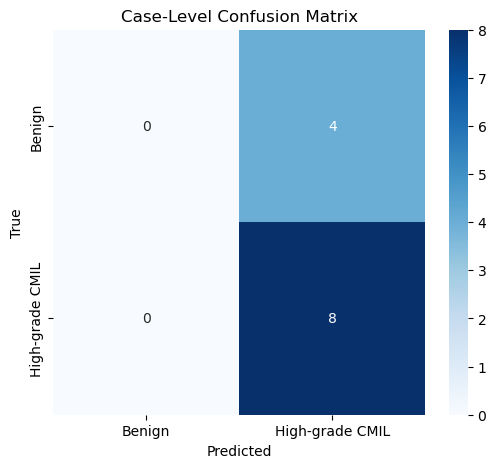

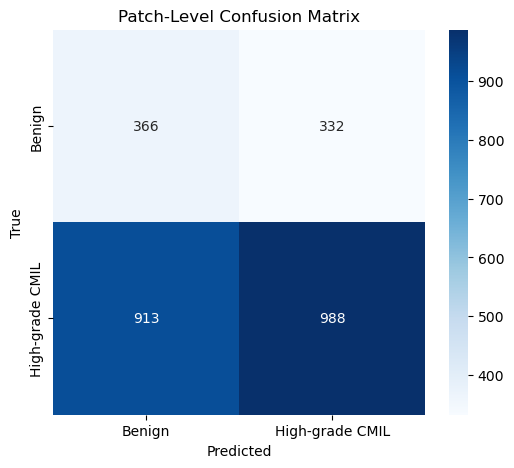

In [15]:
# ------------------- Evaluation -------------------
model.eval()
all_preds, all_trues = [], []
all_patch_preds, all_patch_trues = [], []

with torch.no_grad():
    for X_bag, y in test_loader:
        X_bag, y = X_bag.to(device), y.to(device)

        # Case-level prediction
        bag_logits, patch_logits, mu, logvar = model(X_bag)
        bag_pred = bag_logits.argmax(dim=1)
        all_preds.extend(bag_pred.cpu().numpy())
        all_trues.extend(y.cpu().numpy())

        # Patch-level prediction (weak supervision)
        _, patch_logits, _, _ = model(X_bag)
        patch_pred = patch_logits.argmax(dim=2).squeeze(0).cpu().numpy()
        patch_labels = y.cpu().item() * np.ones_like(patch_pred)

        all_patch_preds.extend(patch_pred)
        all_patch_trues.extend(patch_labels)

# Reports
print("=== Case-Level Classification Report ===")
print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

print("\n=== Patch-Level Classification Report (weak labels) ===")
print(classification_report(all_patch_trues, all_patch_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

# Confusion matrices
for name, preds, trues in [
    ("Case-Level", all_preds, all_trues),
    ("Patch-Level", all_patch_preds, all_patch_trues)
]:
    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign','High-grade CMIL'],
                yticklabels=['Benign','High-grade CMIL'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

In [17]:
def visualize_most_relevant_patch_focusmil(model, test_ds, num_cases=5):
    model.eval()
    selected_indices = random.sample(range(len(test_ds)), num_cases)

    for idx in selected_indices:
        bag, label = test_ds[idx]
        bag = bag.unsqueeze(0).to(next(model.parameters()).device)
        label = label.item()

        with torch.no_grad():
            bag_logits, patch_logits, _, _ = model(bag)
            pred = bag_logits.argmax(dim=1).item()
            correct = (pred == label)
            patch_scores = torch.softmax(patch_logits, dim=2)[0, :, 1].cpu().numpy()  # class 1 prob

        patch_paths = test_ds.bags[idx]
        bag_tensor = bag.squeeze(0).cpu()

        # 🔥 Find patch with max influence (highest prob for class 1)
        top_idx = patch_scores.argmax()

        # 🖼️ Visualize
        plt.figure(figsize=(3, 3))
        img_tensor = unnormalize(bag_tensor[top_idx], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        patch_img = transforms.ToPILImage()(img_tensor.clamp(0, 1))
        plt.imshow(patch_img)
        plt.axis('off')
        score = patch_scores[top_idx]
        plt.title(f"Score={score:.3f}", fontsize=10)
        plt.suptitle(f"Case {idx} | True: {label} | Pred: {pred} | Correct: {correct}", fontsize=12)
        plt.tight_layout()
        plt.show()

        print(f"🧪 Case #{idx}: Top Patch = {os.path.basename(patch_paths[top_idx])}, Score = {score:.4f}")

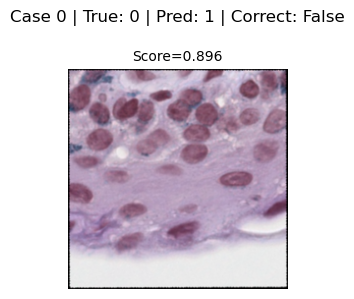

🧪 Case #0: Top Patch = case_28_unmatched_4_h&e_patch67.png, Score = 0.8959


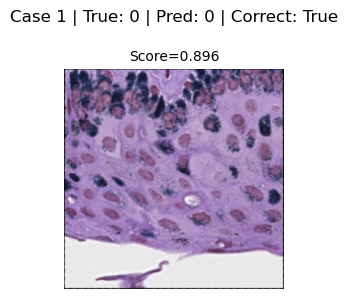

🧪 Case #1: Top Patch = case_056_match_1_h&e_patch16.png, Score = 0.8957


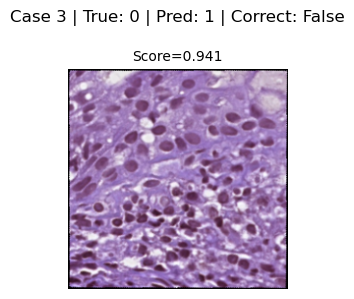

🧪 Case #3: Top Patch = case_46_match_1_h&e_patch23.png, Score = 0.9407


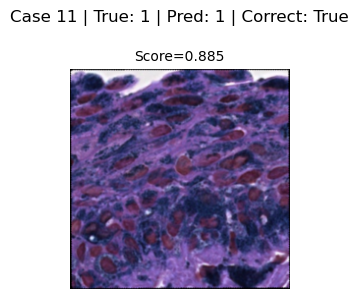

🧪 Case #11: Top Patch = case_064_match_2_h&e_patch18.png, Score = 0.8855


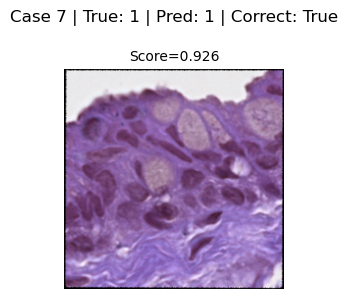

🧪 Case #7: Top Patch = case_48_match_2_h&e_patch142.png, Score = 0.9259


In [18]:
visualize_most_relevant_patch_focusmil(model, test_ds, num_cases=5)
